# Assignment 4: Face Detection and Recognition

## DTSC-680: Applied Machine Learning

## Name:

The `data` directory contains three folders 30 face images of three players from the 2024 Philadelphia Phillies: Alec Bohm, Bryson Stott, and Brandon Marsh. The original images were downloaded from Google Images and the face images were extraced using the `extract_faces` function from the textbook. In addition, the `Samples` directory contains three images of a combination of those players.

Your task is to create a system that can correctly detect and identify Bohm, Stott, and Marsh in those three sample images.

### Install Tensorflow 2.9.2

In [1]:
# CODE PROVIDED
import subprocess
import sys
from IPython.display import clear_output
def check_tensorflow():
    tf_desired_version = "2.9.2"

    try:
        import tensorflow as tf
        tf_installed_version = tf.__version__
    except ImportError:
        tf_installed_version = None

    #Check for the right version
    if tf_installed_version != tf_desired_version:
        print(f"Current TensorFlow version: {tf_installed_version}. Installing version {tf_desired_version}...")
        
        # Uninstall the current TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'tensorflow'])
        
        # Install the desired TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'tensorflow=={tf_desired_version}'])

        clear_output()
        
        print(f"TensorFlow version {tf_desired_version} installed successfully. Please restart your kernel to apply the changes.")
    else:
        print(f"TensorFlow version {tf_desired_version} is already installed.")    

check_tensorflow()

TensorFlow version 2.9.2 is already installed.


In [2]:
# STUDENTS CODE
#Helper functions for loading and displaying the facial images, and declares a pair of lists to hold the images and labels.
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []
    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

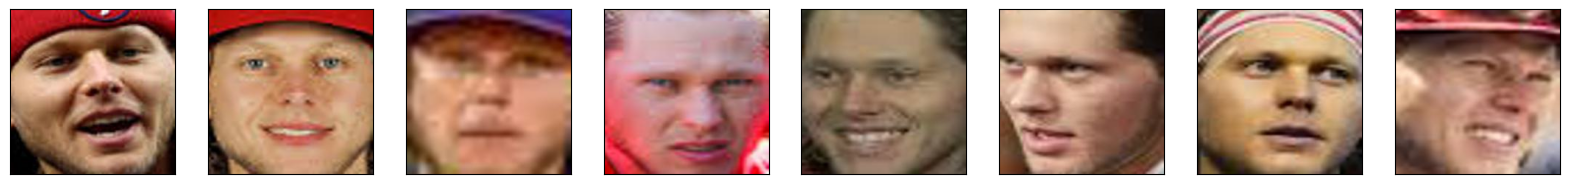

In [3]:
# STUDENTS CODE
# Loading images for Bohm
images, labels = load_images_from_path('data/Bohm',0)
show_images(images)

x += images
y += labels

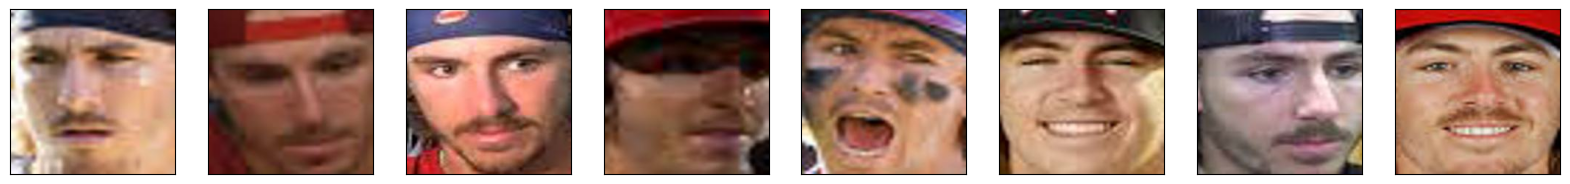

In [4]:
# STUDENTS CODE
# Loading images for Stott
images, labels = load_images_from_path('data/Stott',1)
show_images(images)

x += images
y += labels

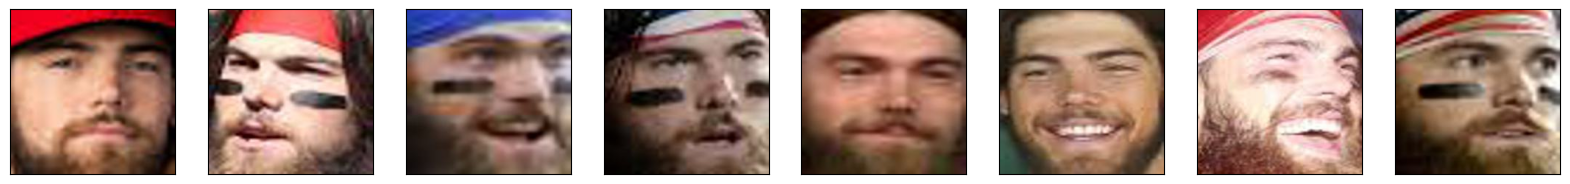

In [5]:
# STUDENTS CODE
# Loading images for Marsh
images, labels = load_images_from_path('data/Marsh',2)
show_images(images)

x += images
y += labels

In [6]:
# STUDENTS CODE
#Preprocess the pixels for the ResNet50 version of VGGface and split the data 50/50 so that the network will be trained with four randomly
# selected images of each person and validated with the same number of images.

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(faces, labels, train_size=0.5, stratify=labels, random_state=0)

In [7]:
# STUDENTS CODE
#load the base model
from tensorflow.keras.models import load_model

base_model = load_model('Data/vggface.h5')
base_model.trainable = False

2024-09-22 15:03:43.405901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# STUDENTS CODE
# Define a network that uses transfer learning with VGGFace to identify faces. We'll add a Resizing layer to ensure that each image measures 244 $\times$ 244 pixels.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
#STUDENTS CODE
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=2, epochs=10)

Epoch 1/10
8/8 [==============================] - 8s 635ms/step - loss: 0.7956 - accuracy: 0.6000 - val_loss: 0.5514 - val_accuracy: 0.8000
Epoch 2/10
8/8 [==============================] - 4s 464ms/step - loss: 0.2662 - accuracy: 0.9333 - val_loss: 0.2118 - val_accuracy: 0.9333
Epoch 3/10
8/8 [==============================] - 3s 461ms/step - loss: 0.1602 - accuracy: 0.9333 - val_loss: 0.1117 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 4s 492ms/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9333
Epoch 5/10
8/8 [==============================] - 4s 503ms/step - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 0.9333
Epoch 6/10
8/8 [==============================] - 4s 489ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0.9333
Epoch 7/10
8/8 [==============================] - 4s 522ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.1726 - val_accuracy: 0.9333
Epoch 8/10
8/8 [====

[]

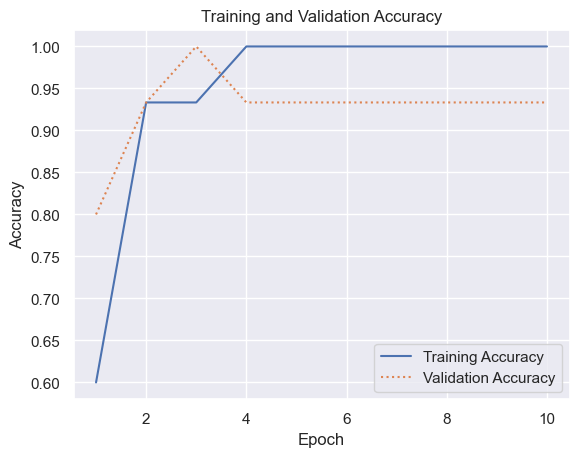

In [10]:
# Visualizing accuracy
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [11]:
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
        
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
        # Optionally draw a box around the face
            if show_outline:
                rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
                ax.add_patch(rect)

            # Label the face
            index = int(np.argmax(predictions))
            text = f'{names[index]} ({confidence:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))

1/1 [==============================] - 0s 150ms/step


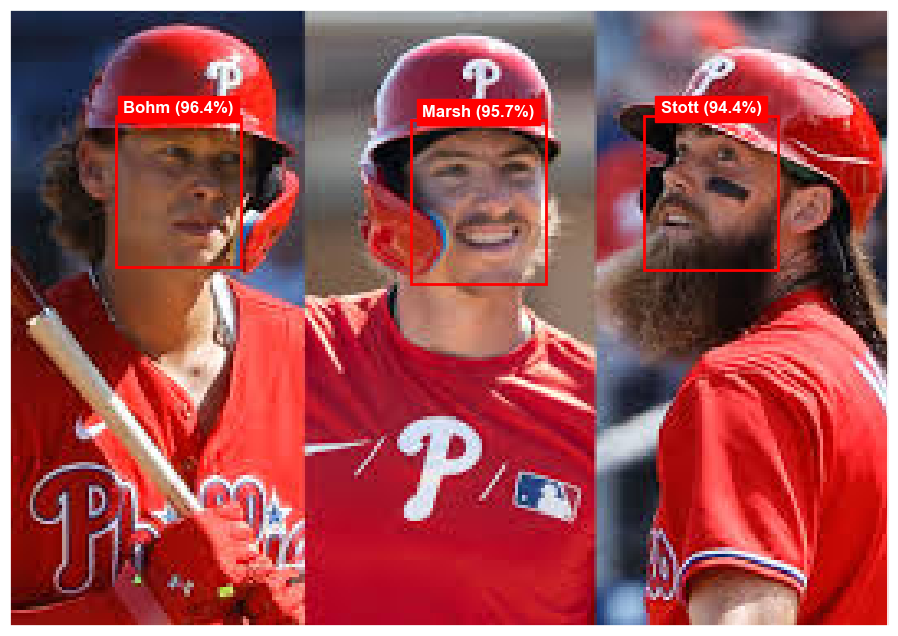

In [12]:
labels = ['Bohm', 'Marsh', 'Stott']
label_faces('data/Samples/Sample-3.jpeg', model, labels)

## Codegrade Validation

### Execute the cells below to generate the file required for submission to Codegrade. DO NOT CHANGE THE CODE.

In [13]:
# CODE PROVIDED
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from PIL import Image, ImageOps
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.resnet50 import preprocess_input


def make_pred(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
            return predictions
            

        return None
        
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def get_all_images_from_directory(directory):
    images = []
    labels = []
    images_names = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            images_names += [img for img in os.listdir(label_path)]
            images += [os.path.join(label_path, img) for img in os.listdir(label_path)]
            labels += [int(label)] * len(os.listdir(label_path))
    
    # Embaralhar as imagens e labels
    combined = list(zip(images_names, images, labels))
    random.shuffle(combined)
    images_names, images, labels = zip(*combined)
    
    #return images_names, images, labels
    return zip(*combined)

def predict_and_validate(model, image_names, image_paths, true_labels, class_labels):
    predictions = []
    for img_path in image_paths:
        predictions.append(make_pred(img_path, model, class_labels, prediction_threshold=0.8))
    
    results = [true == pred for true, pred in zip(true_labels, predictions)]
    
    df = pd.DataFrame({
        'Player': image_names,
        'Prediction Array': predictions
    })
    
    return df

In [14]:
# CODE PROVIDED
from IPython.display import clear_output

model_to_evaluate = model  #MAKE SURE TO USE YOUR MODEL

class_labels = {0: 'Alec Bohm', 1: 'Bryson Stott', 2: 'Brandon Marsh'} 
image_names, image_paths, true_labels = get_all_images_from_directory('data/codegrade_test/')
prediction_df = predict_and_validate(model_to_evaluate, image_names, image_paths, true_labels, class_labels)
clear_output()
prediction_df

,Player,Prediction Array
0,Brandon_07.png,"[[0.013614367, 8.581396e-09, 0.98638564]]"
1,alec_07.jpg,"[[0.992967, 3.0917508e-06, 0.007029958]]"
2,Bryson_09.png,"[[1.2053476e-05, 0.9999877, 2.7944196e-07]]"
3,Brandon_03.png,"[[0.017534591, 9.4478814e-08, 0.98246527]]"
4,Bryson_06.png,"[[0.00051867927, 0.99899954, 0.00048188385]]"
5,alec_01.jpg,"[[0.9992793, 9.4048596e-07, 0.00071972125]]"
6,Bryson_04.png,"[[2.4762601e-05, 0.99996984, 5.405244e-06]]"
7,Brandon_04.png,"[[0.020898318, 3.40412e-09, 0.97910166]]"
8,alec_02.jpg,"[[0.998585, 4.828472e-07, 0.0014145317]]"
9,Brandon_08.png,"[[0.014847688, 4.4954533e-09, 0.98515224]]"


### Export Prediction Array for Codegrade evaluation


In [15]:
# CODE PROVIDED
import pandas as pd

#export your classification model
prediction_df.to_pickle('prediction_df')